In [1]:
%load_ext autoreload
%autoreload 2

## Dataset

In [2]:
from src.datasets import ImagenetContrastive


dataset = ImagenetContrastive('dataset/imagenet', 'train')
dataset[0]

(tensor([[[ 1.0251,  1.0244,  1.0218,  ...,  0.8961,  0.8918,  0.8904],
          [ 1.0296,  1.0289,  1.0259,  ...,  0.9000,  0.8967,  0.8954],
          [ 1.0398,  1.0385,  1.0338,  ...,  0.9115,  0.9100,  0.9092],
          ...,
          [-0.4124, -0.2840,  0.0326,  ...,  1.0801,  0.7943,  0.6239],
          [-0.1788, -0.0675,  0.2206,  ...,  1.0623,  0.7417,  0.5537],
          [-0.0903,  0.0106,  0.2795,  ...,  1.0404,  0.7126,  0.5215]],
 
         [[ 1.6684,  1.6677,  1.6652,  ...,  1.5543,  1.5533,  1.5528],
          [ 1.6733,  1.6725,  1.6693,  ...,  1.5594,  1.5588,  1.5584],
          [ 1.6853,  1.6833,  1.6777,  ...,  1.5697,  1.5697,  1.5697],
          ...,
          [-0.0676,  0.0610,  0.3644,  ...,  1.1076,  0.8734,  0.7297],
          [ 0.1592,  0.2650,  0.5247,  ...,  1.0943,  0.8248,  0.6625],
          [ 0.2401,  0.3326,  0.5666,  ...,  1.0767,  0.7969,  0.6296]],
 
         [[ 2.2095,  2.2097,  2.2091,  ...,  2.2189,  2.2209,  2.2216],
          [ 2.2108,  2.2112,

In [1]:
from src.train_utils import TinyImagenetDatasetRAM

dataset = TinyImagenetDatasetRAM(
    path='dataset/tiny-imagenet-200',
    split='train'
)

In [3]:
len(dataset) // 64

1562

In [1]:
from src.train_utils import TinyImagenetDataset

path = '/home/ilya/repos/tiny-imagenet-clf/dataset/tiny-imagenet-200'
dataset = TinyImagenetDataset(path, 'val')

In [3]:
dataset[100]

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64>, 2)

## Calculate Statistics for Normalization

In [4]:
import torchvision.transforms.v2 as T

aug_transforms = T.Compose([
    T.RandomResizedCrop(size=(64, 64), scale=(0.3, 1), antialias=True),
    T.RandomHorizontalFlip(p=0.5),
    T.ColorJitter(brightness=(.6,1.4),hue=0.2,saturation=(.6,1.4)),
    T.ToTensor(),
    # T.Normalize(mean=[0.4824, 0.4495, 0.3981], std=[0.2765, 0.2691, 0.2825]),
])

/home/ilya/repos/tiny-imagenet-clf/.venv/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [5]:
from src.train_utils import TinyImagenetDataset

dataset = TinyImagenetDatasetRAM(
    path='/home/ilya/repos/tiny-imagenet-clf/dataset/tiny-imagenet-200',
    split='val',
    transforms=aug_transforms
)

In [6]:
import torch

sums = torch.zeros(3)
for i in range(len(dataset)):
    sums += dataset[i][0].sum(dim=(1,2)) / 64 ** 2
sums

tensor([4649.7646, 4341.5728, 3944.1201])

In [7]:
means = sums / len(dataset)
means

tensor([0.4650, 0.4342, 0.3944])

In [8]:
_means = means[:, None, None]
shift_sums = torch.zeros(3)
for i in range(len(dataset)):
    img = dataset[i][0]
    shift_sums += (img - _means).pow(2).sum(dim=(1,2)) / 64 ** 2
shift_sums

tensor([744.6699, 745.9525, 732.8365])

In [9]:
std = shift_sums.div(len(dataset)).pow(0.5)
std

tensor([0.2729, 0.2731, 0.2707])

## Test Model

In [1]:
from src.models.models import se_resnet20

model = se_resnet20()

In [2]:
import torchvision.transforms.v2 as T
import torch

ordinary_transforms = T.Compose([
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.Normalize(mean=[0.4824, 0.4495, 0.3981], std=[0.2765, 0.2691, 0.2825])
])

In [3]:
from src.train_utils import TinyImagenetDataset


path='/home/ilya/repos/tiny-imagenet-clf/dataset/tiny-imagenet-200'
train_dataset = TinyImagenetDataset(path=path, split='train', transforms=ordinary_transforms)
val_dataset = TinyImagenetDataset(path=path, split='val', transforms=ordinary_transforms)

from torch.utils.data import DataLoader
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=4
)

In [4]:
images, targets = next(iter(train_loader))

In [5]:
model(images).shape

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x65536 and 256x200)

## Augmentations

In [3]:
import torchvision.transforms.v2 as T
import torch


ordinary_transforms = T.Compose([
    T.ToTensor(),
    # T.ToDtype(torch.float32, scale=True),
    # T.Normalize(mean=[0.4824, 0.4495, 0.3981], std=[0.2765, 0.2691, 0.2825]),
])

aug_transforms = T.Compose([
    T.RandomResizedCrop(size=(64, 64), scale=(0.3, 1), antialias=True),
    T.RandomHorizontalFlip(p=0.5),
    T.ToTensor(),
    # T.Normalize(mean=[0.4824, 0.4495, 0.3981], std=[0.2765, 0.2691, 0.2825]),
])

/home/ilya/repos/tiny-imagenet-clf/.venv/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [4]:
from src.train_utils import TinyImagenetDataset

path = '/home/ilya/repos/tiny-imagenet-clf/dataset/tiny-imagenet-200'
orig_dataset = TinyImagenetDataset(path=path, split='val', transforms=ordinary_transforms)
aug_dataset = TinyImagenetDataset(path=path, split='val', transforms=aug_transforms)

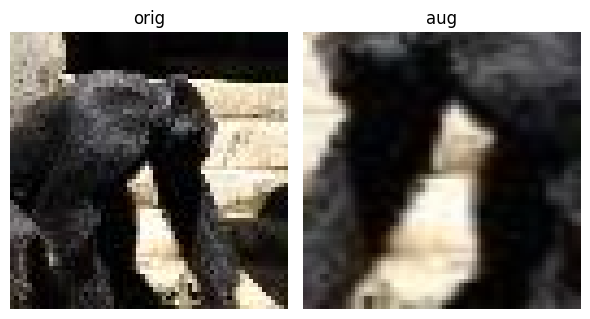

In [18]:
import matplotlib.pyplot as plt
import numpy as np

def get_sample(i, dataset):
    img, _ = dataset[i]
    return np.array(img).transpose((1, 2, 0))


i_sample = 701
orig = get_sample(i_sample, orig_dataset)
aug = get_sample(i_sample, aug_dataset)

fig, ax = plt.subplots(1, 2, figsize=(6,6))
ax[0].imshow(orig)
ax[1].imshow(aug)

ax[0].set_title('orig')
ax[1].set_title('aug')

ax[0].axis('off')
ax[1].axis('off')

plt.tight_layout()

In [34]:
from torch.utils.data import DataLoader, default_collate

N_CLASSES = 200

cutmix = T.CutMix(num_classes=N_CLASSES)
mixup = T.MixUp(num_classes=N_CLASSES)
cutmix_or_mixup = T.RandomChoice([cutmix, mixup])

def collate_fn(batch):
    return cutmix_or_mixup(*default_collate(batch))

orig_loader = DataLoader(
    dataset=orig_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    drop_last=True,
    # collate_fn=collate_fn
)
aug_loader = DataLoader(
    dataset=orig_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    drop_last=True,
    collate_fn=collate_fn
)

In [38]:
next(iter(orig_loader))

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/ilya/repos/tiny-imagenet-clf/.venv/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/ilya/repos/tiny-imagenet-clf/.venv/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 54, in fetch
    return self.collate_fn(data)
  File "/home/ilya/repos/tiny-imagenet-clf/.venv/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 265, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
  File "/home/ilya/repos/tiny-imagenet-clf/.venv/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 142, in collate
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
  File "/home/ilya/repos/tiny-imagenet-clf/.venv/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 142, in <listcomp>
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
  File "/home/ilya/repos/tiny-imagenet-clf/.venv/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 119, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
  File "/home/ilya/repos/tiny-imagenet-clf/.venv/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 162, in collate_tensor_fn
    return torch.stack(batch, 0, out=out)
RuntimeError: stack expects each tensor to be equal size, but got [1, 64, 64] at entry 0 and [3, 64, 64] at entry 1


In [36]:
import matplotlib.pyplot as plt
import numpy as np

def get_sample(i, dataloader):
    img, tar = next(iter(dataloader))
    return img[i].permute((1,2,0)), tar[i] 


i_sample = 1
orig_img, orig_tar = get_sample(i_sample, orig_loader)
aug_img, aug_tar = get_sample(i_sample, aug_loader)

fig, ax = plt.subplots(1, 2, figsize=(6,6))
ax[0].imshow(orig_img)
ax[1].imshow(aug_img)

ax[0].set_title('orig')
ax[1].set_title('aug')

ax[0].axis('off')
ax[1].axis('off')

plt.tight_layout()

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/ilya/repos/tiny-imagenet-clf/.venv/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/ilya/repos/tiny-imagenet-clf/.venv/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 54, in fetch
    return self.collate_fn(data)
  File "/home/ilya/repos/tiny-imagenet-clf/.venv/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 265, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
  File "/home/ilya/repos/tiny-imagenet-clf/.venv/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 142, in collate
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
  File "/home/ilya/repos/tiny-imagenet-clf/.venv/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 142, in <listcomp>
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
  File "/home/ilya/repos/tiny-imagenet-clf/.venv/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 119, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
  File "/home/ilya/repos/tiny-imagenet-clf/.venv/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 162, in collate_tensor_fn
    return torch.stack(batch, 0, out=out)
RuntimeError: stack expects each tensor to be equal size, but got [1, 64, 64] at entry 0 and [3, 64, 64] at entry 1


In [19]:
orig_img.shape, orig_tar

(torch.Size([3, 64, 64]), tensor(98))

In [20]:
aug_img.shape, aug_tar.shape

(torch.Size([3, 64, 64]), torch.Size([200]))

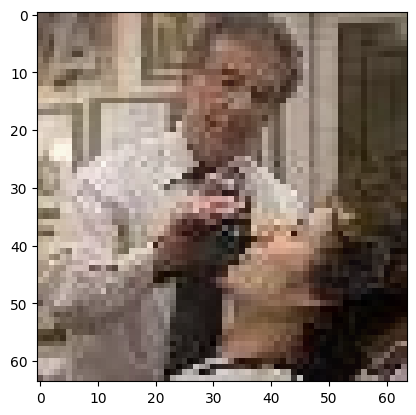

In [23]:
plt.imshow(aug_img.permute((1,2,0)))

## Contrastive model validation

In [7]:
import numpy as np

def generate_data(n_samples, n_classes, n_features):
    X = np.random.normal(size=(n_samples, n_features))
    W = np.random.normal(size=(n_features, n_classes))
    y = np.argmax(X @ W, axis=1)

    delim = int(0.95 * n_samples)
    X_train = X[:delim]
    y_train = y[:delim]
    X_val = X[delim:]
    y_val = y[delim:]

    train_dataset = list(zip(X_train, y_train))
    val_dataset = list(zip(X_val, y_val))

    return train_dataset, val_dataset

In [24]:
train_dataset, val_dataset = generate_data(
    n_samples=500,
    n_classes=20,
    n_features=32
)

In [25]:
from src.learners.contrastive import get_clf_score

get_clf_score(train_dataset, val_dataset, n_epochs=200)

0.72

In [7]:
from src.train_utils import load_and_freeze_model
from src.models import se_resnet10
model = se_resnet10()
print(model.fc.weight.data)
model2 = load_and_freeze_model(
    'logs/lightning_logs/u9r3zm8p/checkpoints/epoch=0-step=12000.ckpt',
    model
)
print(model2.fc.weight.data)

tensor([[ 0.0789, -0.0695, -0.0334,  ...,  0.1147, -0.0999,  0.0124],
        [-0.0069, -0.0300, -0.0326,  ...,  0.0814, -0.0939,  0.0767],
        [ 0.0499,  0.0661,  0.0013,  ..., -0.1054,  0.0042,  0.1027],
        ...,
        [ 0.0177,  0.0841,  0.0638,  ..., -0.1125,  0.0615,  0.0360],
        [-0.0316, -0.0423, -0.0646,  ...,  0.0713, -0.0771,  0.0632],
        [ 0.0780,  0.0877,  0.0770,  ..., -0.0991, -0.0979, -0.0559]])
i am here
tensor([[ 0.0502,  0.0174,  0.1350,  ...,  0.0992, -0.0104, -0.0278],
        [-0.0858, -0.1079,  0.1577,  ...,  0.0742, -0.1157, -0.0260],
        [-0.0676,  0.1515, -0.0561,  ..., -0.0531,  0.0142, -0.0060],
        ...,
        [ 0.0365, -0.0428,  0.0188,  ..., -0.0440,  0.0190, -0.1307],
        [ 0.0005, -0.1058,  0.1111,  ..., -0.0107,  0.0653, -0.0851],
        [-0.0390, -0.0672, -0.0859,  ...,  0.0083,  0.0633, -0.1036]],
       device='cuda:0')


In [54]:
import math

lr_min = 0.02
lr_max = 0.1
warmup_steps = None
max_steps = 1000
def cosine_annealing_with_warmup(step):
    if warmup_steps is not None:
        if step < warmup_steps:
            return lr_max - 0.5 * lr_max * (1 + math.cos(step / warmup_steps * math.pi))
        step -= warmup_steps
    
    return lr_min + 0.5 * (lr_max - lr_min) * (1 + math.cos(step / max_steps * math.pi))


In [55]:
x = range(1, max_steps+1)
y = list(map(cosine_annealing_with_warmup, x))

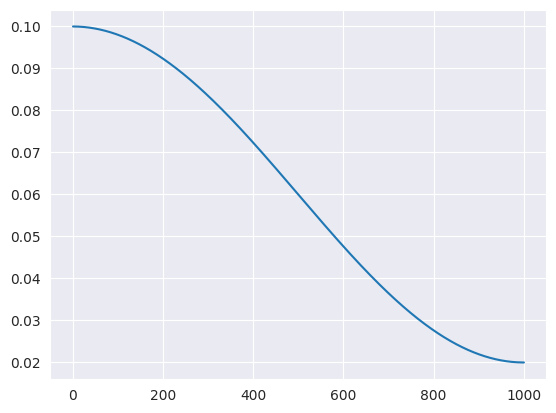

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

plt.plot(x, y)
plt.show()

## Timm models

In [90]:
import timm
lst = timm.list_models()
lst
# list(filter(lambda x: x.find('34') != -1, lst))

['bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_large_patch16_224',
 'botnet26t_256',
 'botnet50ts_256',
 'caformer_b36',
 'caformer_m36',
 'caformer_s18',
 'caformer_s36',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_medium',
 'coat_lite_medium_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_small',
 'coat_tiny',
 'coatnet_0_224',
 'coatnet_0_rw_224',
 'coatnet_1_224',
 'coatnet_1_rw_224',
 'coatnet_2_224',
 'coatnet_2_rw_224',
 'coatnet_3_224',
 'coatnet_3_rw_224',
 'coatnet_4_224',
 'coatnet_5_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_cc_224',
 'coatnet_nano_rw_224',
 'coatnet_pico_rw_224',
 'coatnet_rmlp_0_rw_224',
 'coatnet_rmlp_1_rw2_224',
 'coatnet_rmlp_1_r

In [77]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [97]:
import timm
model = timm.create_model('resnet18', pretrained=False)
print(count_parameters(model))
# model.layer1[1].bn1.bias

11689512


Identity()

## Inference

In [1]:

N_CLASSES = 200

# import argparse
# ap = argparse.ArgumentParser()
# ap.add_argument('--model', dest='model', choices=[
#     'myresnet-base', 'myresnet-small', 'seresnet18', 'seresnext', 'skresnet', 'seresnet34'
# ], required=True)
# ap.add_argument('--name-out', dest='name', required=True)
# ap.add_argument('--seed', dest='seed', default=0, type=int)
# ap.add_argument('--n_workers', dest='n_workers', default=2, type=int)
# ap.add_argument('--batch_size', dest='batch_size', default=64, type=int)
# ap.add_argument('--weights-from', dest='weights_from', default=None)
# args = ap.parse_args()

from typing import Literal
from dataclasses import dataclass
@dataclass
class Args:
    name: str
    weights_from: str
    model: Literal['myresnet-base', 'myresnet-small', 'seresnet18', 'seresnext', 'skresnet', 'seresnet34']
    seed: int
    n_workers: int
    batch_size: int
args = Args(
    name = 'test-name',
    weights_from = 'weights/seresnet34.ckpt',
    model = 'seresnet34',
    seed = 0,
    n_workers = 8,
    batch_size = 64
)

from src.train_utils import init_environment
init_environment(args)

# === model and learner ===
from src.models import MyResNet, get_seresnext, get_seresnet, get_skresnet, get_seresnet34
if args.model == 'myresnet-small':
    model_ = MyResNet(planes=32)
elif args.model == 'myresnet-base':
    model_ = MyResNet(planes=64)
elif args.model == 'seresnet18':
    model_ = get_seresnet()
elif args.model == 'seresnext':
    model_ = get_seresnext()
elif args.model == 'skresnet':
    model_ = get_skresnet()
elif args.model == 'seresnet34':
    model_ = get_seresnet34()

from src.learners import ClfLearner, ClfLearnerConfig
config = ClfLearnerConfig(batch_size=args.batch_size)
learner = ClfLearner(model_, config)

# === data ===
import torchvision.transforms.v2 as T

ordinary_transforms = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.4824, 0.4495, 0.3981], std=[0.2765, 0.2691, 0.2825]),
])

import os
path = os.path.join('.', 'dataset', 'tiny-imagenet-200')

from src.datasets import TinyImagenetDatasetRAM
train_dataset = TinyImagenetDatasetRAM(path=path, split='train', transforms=ordinary_transforms)
val_dataset = TinyImagenetDatasetRAM(path=path, split='val', transforms=ordinary_transforms)
test_dataset = TinyImagenetDatasetRAM(path=path, split='test', transforms=ordinary_transforms)

from torch.utils.data import DataLoader
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=args.batch_size,
    shuffle=False,
    num_workers=args.n_workers,
    drop_last=True
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=args.batch_size,
    shuffle=False,
    num_workers=args.n_workers
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=args.batch_size,
    shuffle=False,
    num_workers=args.n_workers
)

# === trainer ===
import lightning.pytorch as pl

trainer = pl.Trainer(
    # max_epochs=args.max_epochs,
    # max_time={'hours': 10},
    
    # max_time={'minutes': 10},

    # hardware settings
    accelerator='gpu',
    deterministic=True,
    precision="16-mixed",

    # logging and checkpointing
    # val_check_interval=args.interval,
    # check_val_every_n_epoch=args.interval,
    logger=False,
    enable_progress_bar=True,
    profiler=None,
    # callbacks=callbacks,
    # log_every_n_steps=5,

    # check if model is implemented correctly
    overfit_batches=False,

    # check training_step and validation_step doesn't fail
    fast_dev_run=False,
    num_sanity_val_steps=False
)

trainer.validate(learner, train_loader, ckpt_path=args.weights_from)
trainer.validate(learner, val_loader, ckpt_path=args.weights_from)

/home/ilya/repos/tiny-imagenet-clf/.venv/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at weights/seresnet34.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at weights/seresnet34.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

/home/ilya/repos/tiny-imagenet-clf/.venv/lib/python3.10/site-packages/lightning/pytorch/core/module.py:491: You called `self.log('val_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/ilya/repos/tiny-imagenet-clf/.venv/lib/python3.10/site-packages/lightning/pytorch/core/module.py:491: You called `self.log('val_metric', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
Restoring states from the checkpoint path at weights/seresnet34.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.7876957058906555
       val_metric           0.8398087620735168
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at weights/seresnet34.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss             2.009063720703125
       val_metric           0.5439000129699707
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 2.009063720703125, 'val_metric': 0.5439000129699707}]

In [2]:
test_preds = trainer.predict(learner, test_loader, ckpt_path=args.weights_from)

Restoring states from the checkpoint path at weights/seresnet34.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at weights/seresnet34.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

In [18]:
import pandas as pd
import torch


def predict_val(args):
    # load weights
    learner = ClfLearner.load_from_checkpoint(
        checkpoint_path=args.weights_from,
        model=model_,
        config=ClfLearnerConfig()
    )

    # predict
    all_preds = []
    true = 0
    for batch in val_loader:
        images = batch[0].cuda()
        targets = batch[1]
        pred_labels = learner.predict_step(images).argmax(1).cpu()
        all_preds.append(pred_labels)
        true += torch.count_nonzero(targets == pred_labels).item()
    all_preds = torch.concat(all_preds)
    print('val accuracy:', true / len(all_preds))

    # map files to class names
    dataset = TinyImagenetDatasetRAM(
        path='dataset/tiny-imagenet-200',
        split='val',
    )
    all_names = dataset.class_directories
    image_file_names = dataset.image_names
    return pd.DataFrame({
        'id': [image_file_names[i_class][i%50] for i, i_class in enumerate(all_preds)],
        'pred': [all_names[i_class] for i_class in all_preds]
    })
    

In [19]:
predict_val(args)

val accuracy: 0.5439


,id,pred
0,val_925.JPEG,n02504458
1,val_2358.JPEG,n02410509
2,val_1241.JPEG,n02504458
3,val_8301.JPEG,n01945685
4,val_4333.JPEG,n02950826
...,...,...
9995,val_2644.JPEG,n07695742
9996,val_1272.JPEG,n07695742
9997,val_9705.JPEG,n07695742
9998,val_7503.JPEG,n01983481


In [44]:
import pandas as pd
import torch


def predict_test(args):
    # load weights
    learner = ClfLearner.load_from_checkpoint(
        checkpoint_path=args.weights_from,
        model=model_,
        config=ClfLearnerConfig()
    )

    # predict
    all_preds = []
    for batch in test_loader:
        images = batch.cuda()
        pred_labels = learner.predict_step(images).argmax(1).cpu()
        all_preds.append(pred_labels)
    all_preds = torch.concat(all_preds)

    # map files to class names
    dataset = TinyImagenetDatasetRAM(
        path='dataset/tiny-imagenet-200',
        split='val',
    )
    all_names = dataset.class_directories
    dataset = TinyImagenetDatasetRAM(
        path='dataset/tiny-imagenet-200',
        split='test',
    )
    image_file_names = dataset.image_names
    return pd.DataFrame({
        'id': [image_file_names[i] for i, i_class in enumerate(all_preds)],
        'pred': [all_names[i_class] for i_class in all_preds]
    }).set_index('id')
    

In [45]:
predict_test(args)

,pred
id,
test_538.JPEG,n03250847
test_8856.JPEG,n04259630
test_9542.JPEG,n04285008
test_3009.JPEG,n02415577
test_4004.JPEG,n04133789
...,...
test_901.JPEG,n03662601
test_1489.JPEG,n03637318
test_5235.JPEG,n01698640


In [15]:
# load weights
learner = ClfLearner.load_from_checkpoint(
    checkpoint_path=args.weights_from,
    model=model_,
    config=ClfLearnerConfig()
)

# predict
all_preds = []
for batch in val_loader:
    images = batch[0].cuda()
    targets = batch[1].cuda()
    all_preds.append(learner.predict_step(images).argmax(1).cpu())
all_preds = torch.concat(all_preds)


# map to class names
from src.datasets import TinyImagenetDatasetRAM

dataset = TinyImagenetDatasetRAM(
    path='dataset/tiny-imagenet-200',
    split='val',
)
names = dataset.class_directories

# map to class descriptions
import pandas as pd
words = pd.read_csv('dataset/tiny-imagenet-200/words.txt', sep='\t', names=['name', 'word'], index_col='name')
words = words.to_dict()['word']

In [13]:
import matplotlib.pyplot as plt

def show(i):
    img, lab = dataset[i]
    print(f'true: {lab} / {names[lab]} / {words[names[lab]]}')
    lab = all_preds[i]
    print(f'pred: {lab} / {names[lab]} / {words[names[lab]]}')
    plt.imshow(img)

true: 199 / n07695742 / pretzel
pred: 199 / n07695742 / pretzel


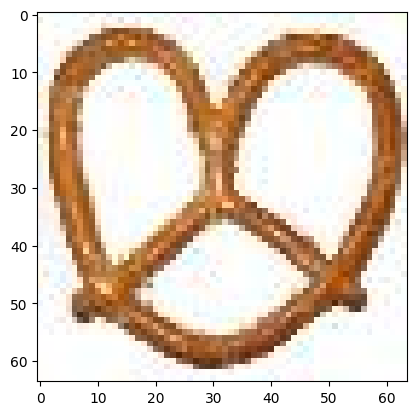

In [17]:
show(9999)

In [25]:
# load weights
learner = ClfLearner.load_from_checkpoint(
    checkpoint_path=args.weights_from,
    model=model_,
    config=ClfLearnerConfig()
)

# predict
all_preds = []
for batch in test_loader:
    images = batch.cuda()
    all_preds.append(learner.predict_step(images).argmax(1).cpu())
all_preds = torch.concat(all_preds)


# map to class names
from src.datasets import TinyImagenetDatasetRAM

dataset = TinyImagenetDatasetRAM(
    path='dataset/tiny-imagenet-200',
    split='test',
)

# map to class descriptions
import pandas as pd
words = pd.read_csv('dataset/tiny-imagenet-200/words.txt', sep='\t', names=['name', 'word'], index_col='name')
words = words.to_dict()['word']

In [28]:
import matplotlib.pyplot as plt

def show(i):
    img = dataset[i]
    lab = all_preds[i]
    print(f'pred: {lab} / {names[lab]} / {words[names[lab]]}')
    plt.imshow(img)

pred: 24 / n02837789 / bikini, two-piece


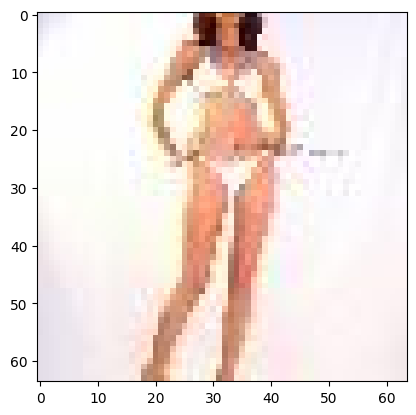

In [41]:
show(12)

In [1]:
import pandas as pd
df_1 = pd.read_csv('submissions/seresnet34-2-subm.csv')
df_2 = pd.read_csv('submissions/subm.csv')

df_1.sort_values('id', inplace=True)
df_2.sort_values('id', inplace=True)

In [3]:
mask = (df_1.pred != df_2.pred)
df_1[mask], df_2[mask]

(                   id       pred
 11584  test_2423.JPEG  n04251144
 12314  test_3080.JPEG  n03599486
 17602  test_7840.JPEG  n02837789
 19331  test_9397.JPEG  n04179913
 1875    val_4972.JPEG  n02268443
 4382    val_6606.JPEG  n04133789
 4686    val_7903.JPEG  n03089624,
                    id       pred
 11584  test_2423.JPEG  n02841315
 12314  test_3080.JPEG  n04285008
 17602  test_7840.JPEG  n03770439
 19331  test_9397.JPEG  n03179701
 1875    val_4972.JPEG  n02190166
 4382    val_6606.JPEG  n02814533
 4686    val_7903.JPEG  n06596364)